## **Denoising with a Convolutional Autoencoder**

**Imports**

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from google.colab import drive
import os

**Load and Preprocess the Text Image [Dataset](https://drive.google.com/file/d/1_kg9xHF_E4-7smIWIrnPQGH0qBhwoGac/view?usp=sharing)**

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# Unzipping noisy_documents.zip
!unzip -q /content/drive/MyDrive/noisy_documents.zip -d /content/data

(420, 540, 1)


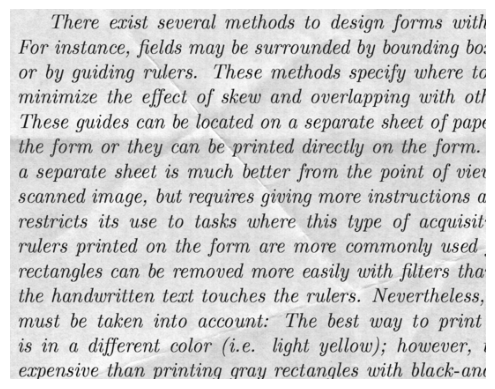

(258, 540, 1)


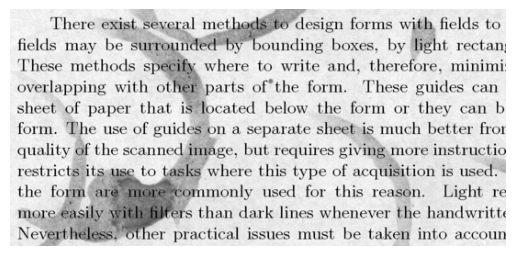

In [4]:
# View the size of the images

image = tf.io.read_file("/content/data/train_noise/149.png")
image = tf.image.decode_png(image, channels=1)
print(image.shape)
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

image = tf.io.read_file("/content/data/train_noise/14.png")
image = tf.image.decode_png(image, channels=1)
print(image.shape)
plt.imshow(image, cmap="gray")
plt.axis("off");

There are two different sizes, so all of them must be resized to have a uniform size. In this case, to the larger size.

In [52]:
batch_size = 32
epochs = 25
buffer_size = 128
image_size = (420, 540)
AUTOTUNE = tf.data.AUTOTUNE

In [35]:
def load_data(directory):
  dataset=tf.keras.utils.image_dataset_from_directory(
      directory=directory,
      labels=None,
      color_mode="grayscale",
      batch_size=None,
      image_size=image_size,
      shuffle=False,
      interpolation="bilinear"
  )
  return dataset

In [36]:
x_train = load_data("/content/data/train_noise")
y_train = load_data("/content/data/train_clean")
x_test = load_data("/content/data/test")

Found 144 files belonging to 1 classes.
Found 144 files belonging to 1 classes.
Found 72 files belonging to 1 classes.


In [37]:
for x_im in x_train.take(1):
  print(x_im.shape)

(420, 540, 1)


In [38]:
x_im.numpy().min(), x_im.numpy().max()

(0.0, 255.0)

In [39]:
def preprocessing(image):
  return tf.cast(image, dtype=tf.float32)/255

In [40]:
x_train = x_train.map(preprocessing)
y_train = y_train.map(preprocessing)
train_dataset = (tf.data.Dataset.zip((x_train, y_train)).
                 shuffle(buffer_size, seed=123).
                 batch(batch_size).
                 prefetch(AUTOTUNE))

x_test = x_test.map(preprocessing).batch(batch_size)

In [41]:
for (x_im, y_im), x_im_test in zip(train_dataset.take(1), x_test.take(1)):
  print(x_im.shape, y_im.shape, x_im_test.shape)

(32, 420, 540, 1) (32, 420, 540, 1) (32, 420, 540, 1)


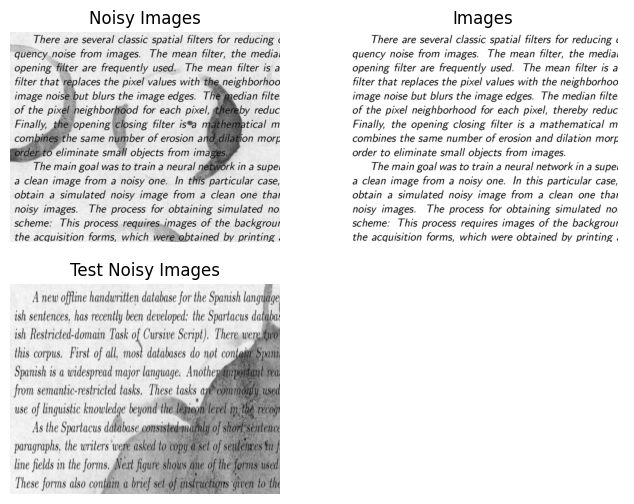

In [42]:
# Visualizing images from the datasets
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

ax[0, 0].imshow(x_im[0], cmap="gray")
ax[0, 0].axis("off")
ax[0, 0].set_title("Noisy Images")

ax[0, 1].imshow(y_im[0], cmap="gray")
ax[0, 1].axis("off")
ax[0, 1].set_title("Images")

ax[1, 0].imshow(x_im_test[0], cmap="gray")
ax[1, 0].axis("off")
ax[1, 0].set_title("Test Noisy Images")

ax[1, 1].axis("off");

**Build the Model**

In [43]:
tf.keras.backend.clear_session()

In [44]:
def build_autoencoder():
  input = tf.keras.Input((420, 540, 1))

  # Encoder
  x = tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding="same", activation="relu")(input)
  x = tf.keras.layers.MaxPooling2D((2,2))(x)

  x = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding="same", activation="relu")(x)
  x = tf.keras.layers.MaxPooling2D((2,2))(x)

  # Bottleneck
  x = tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding="same", activation="relu")(x)
  encoder_visualization = tf.keras.layers.Conv2D(1, kernel_size=(3,3), padding="same", activation="sigmoid")(x)

  # Decoder
  x = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding="same", activation="relu")(x)
  x = tf.keras.layers.UpSampling2D((2,2))(x)

  x = tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding="same", activation="relu")(x)
  x = tf.keras.layers.UpSampling2D((2,2))(x)

  x = tf.keras.layers.Conv2D(1, kernel_size=(3,3), padding="same", activation="sigmoid")(x) #Pixel values range from 0 (black) to 1 (white)

  # Models
  encoder_model = tf.keras.Model(inputs=input, outputs=encoder_visualization)
  autoencoder_model = tf.keras.Model(inputs=input, outputs=x)

  return encoder_model, autoencoder_model

In [45]:
tf.random.set_seed(123) #for reproducibility

encoder_model, autoencoder_model = build_autoencoder()
autoencoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 420, 540, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 210, 270, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 210, 270, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 105, 135, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 105, 135, 256)     2951

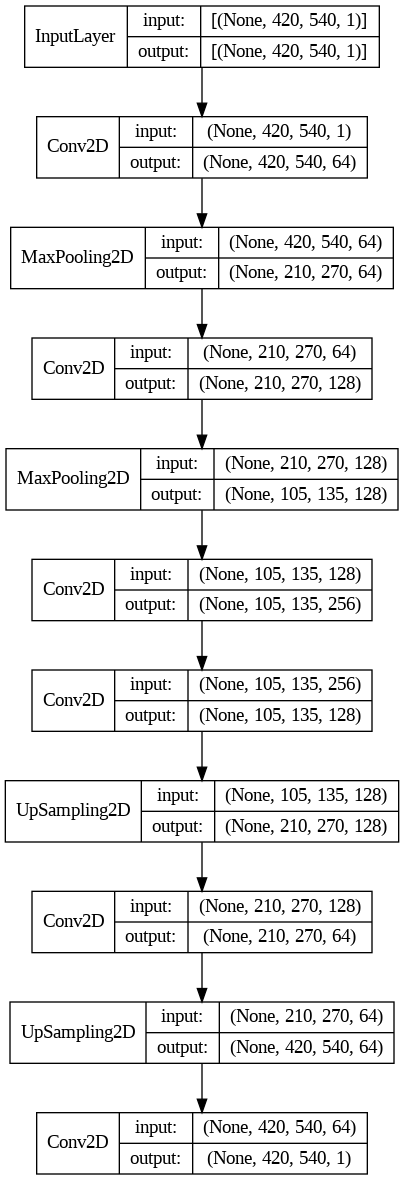

In [49]:
# Autoencoder architecture
tf.keras.utils.plot_model(autoencoder_model, show_shapes=True, show_layer_names=False)

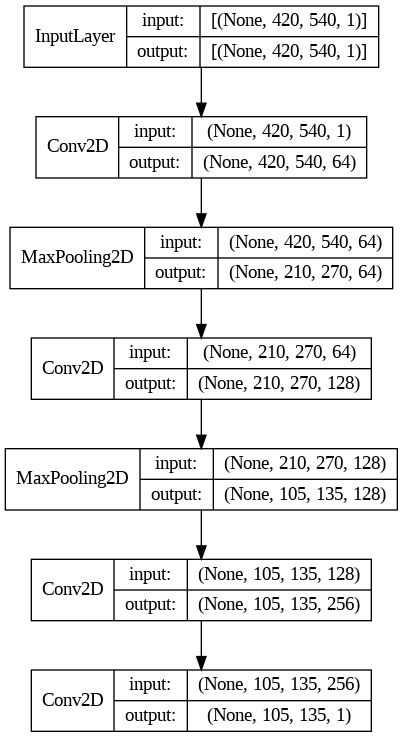

In [50]:
# Encoder architecture
tf.keras.utils.plot_model(encoder_model, show_shapes=True, show_layer_names=False)

**Compile and Train the Model**

In [51]:
autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="binary_crossentropy")

In [54]:
history = autoencoder_model.fit(train_dataset, epochs=epochs, verbose=1)

Epoch 1/25
5/5 [==============================] - 54s 5s/step - loss: 0.5277
Epoch 2/25
5/5 [==============================] - 5s 749ms/step - loss: 0.3791
Epoch 3/25
5/5 [==============================] - 5s 744ms/step - loss: 0.3599
Epoch 4/25
5/5 [==============================] - 5s 746ms/step - loss: 0.3462
Epoch 5/25
5/5 [==============================] - 5s 748ms/step - loss: 0.3266
Epoch 6/25
5/5 [==============================] - 5s 749ms/step - loss: 0.2947
Epoch 7/25
5/5 [==============================] - 5s 751ms/step - loss: 0.2691
Epoch 8/25
5/5 [==============================] - 5s 757ms/step - loss: 0.2579
Epoch 9/25
5/5 [==============================] - 5s 751ms/step - loss: 0.2485
Epoch 10/25
5/5 [==============================] - 5s 764ms/step - loss: 0.2390
Epoch 11/25
5/5 [==============================] - 5s 759ms/step - loss: 0.2259
Epoch 12/25
5/5 [==============================] - 5s 758ms/step - loss: 0.2141
Epoch 13/25
5/5 [==============================] - 

In [6]:
# Function to plot the loss
def plot_metrics(history, renderer=None, epochs=epochs):
  losses = history.history["loss"]
  list_epochs = np.arange(1, epochs+1)

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name="Loss", line=dict(color="blue", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text="Loss")
  fig.update_layout(title=f"Evolution of Loss across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

In [56]:
# Interactive graphic
plot_metrics(history)

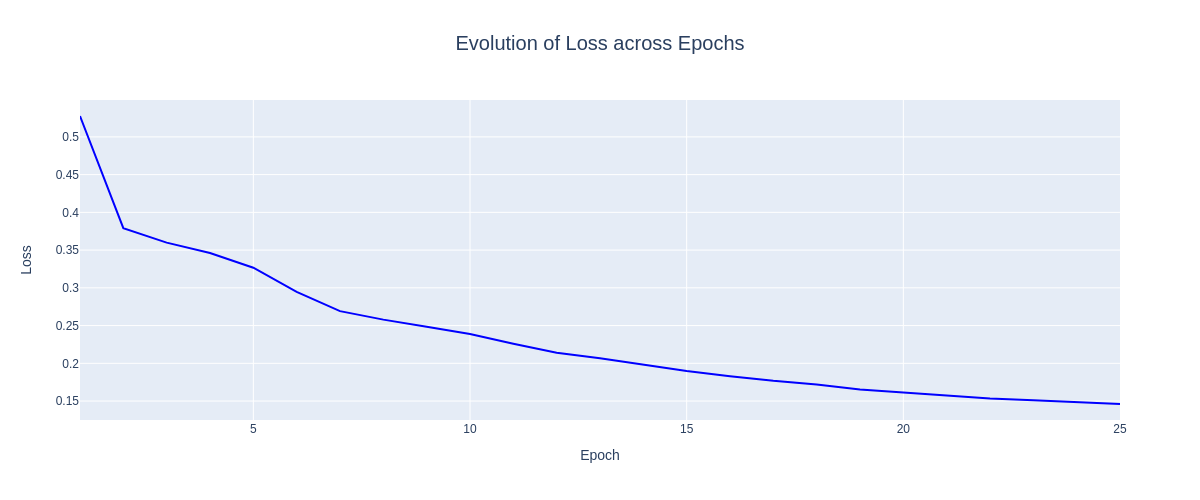

In [7]:
# Image for GitHub
plot_metrics(history, renderer="png")

**Test set results**

In [58]:
# Get images from test images as numpy arrays
images_noisy  = x_test.unbatch().as_numpy_iterator()
images_noisy = np.array(list(images_noisy))

images_noisy.shape

(72, 420, 540, 1)

In [59]:
# Predictions
latent_rep = encoder_model.predict(images_noisy, batch_size=batch_size, verbose=0)
gen_images = autoencoder_model.predict(images_noisy, batch_size=batch_size, verbose=0)

latent_rep.shape, gen_images.shape

((72, 105, 135, 1), (72, 420, 540, 1))

In [60]:
names = ["Noisy Images", "Latent Representation", "Generated Images"]

In [61]:
# Create the images folder

directory_images = "/content/drive/MyDrive/images/autoencoder"
os.makedirs(directory_images, exist_ok=True)

In [73]:
# Function to display images

def show_images(images_noisy, latent_rep, gen_images,
                save=False, num_examples=25, names=names, random=True, cmap="gray"):

  indices = np.arange(len(images_noisy))
  if random:
    np.random.shuffle(indices)

  fig, ax = plt.subplots(num_examples, 3, figsize=(12, num_examples*3))

  for i in range(num_examples):
    ax[i, 0].imshow(images_noisy[indices[i]], cmap="gray")
    ax[i, 0].axis("off")

    ax[i, 1].imshow(latent_rep[indices[i]], cmap="gray")
    ax[i, 1].axis("off")

    ax[i, 2].imshow(gen_images[indices[i]], cmap="gray")
    ax[i, 2].axis("off")

  ax[0, 0].set_title(names[0], fontsize=8, fontweight="bold")
  ax[0, 1].set_title(names[1], fontsize=8, fontweight="bold")
  ax[0, 2].set_title(names[2], fontsize=8, fontweight="bold")

  if save:
    plt.savefig(os.path.join(directory_images, "ConvAutoencoder_Denoising_TextImage.png"),
                transparent=True)

  plt.show()

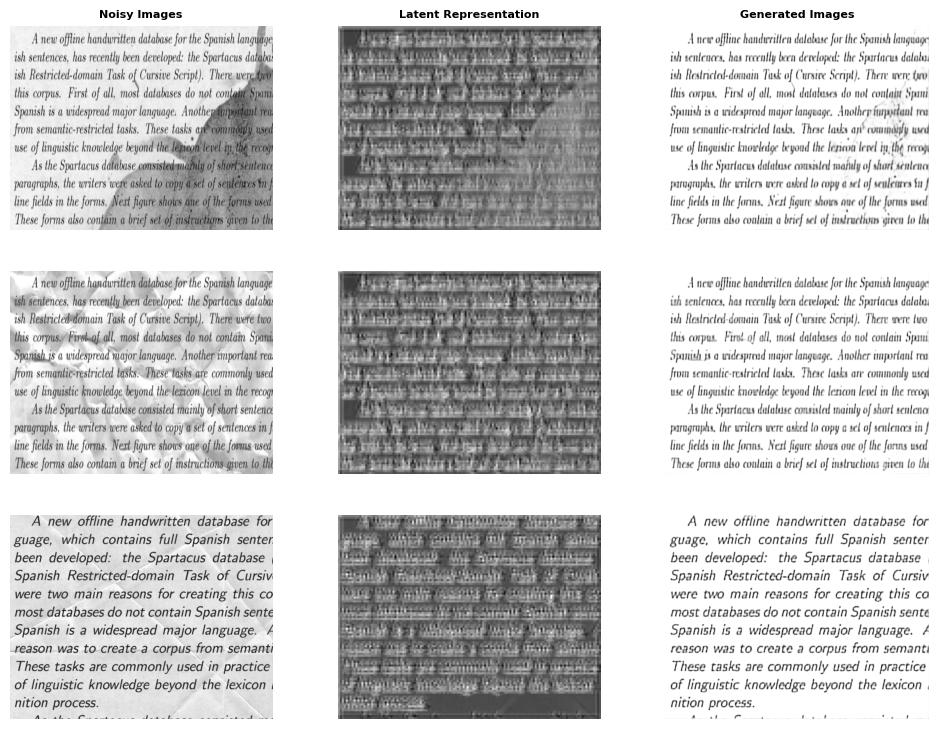

In [82]:
show_images(images_noisy, latent_rep, gen_images, save=True, random=False, num_examples=3)

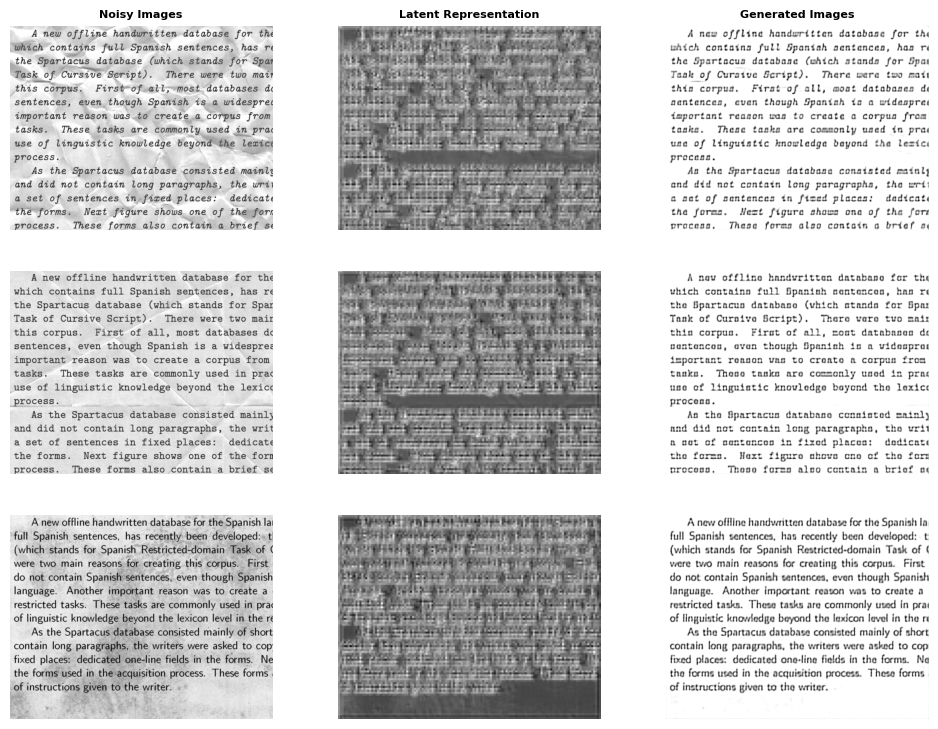

In [88]:
# Save an image with some examples
show_images(images_noisy, latent_rep, gen_images, save=True, num_examples=3)

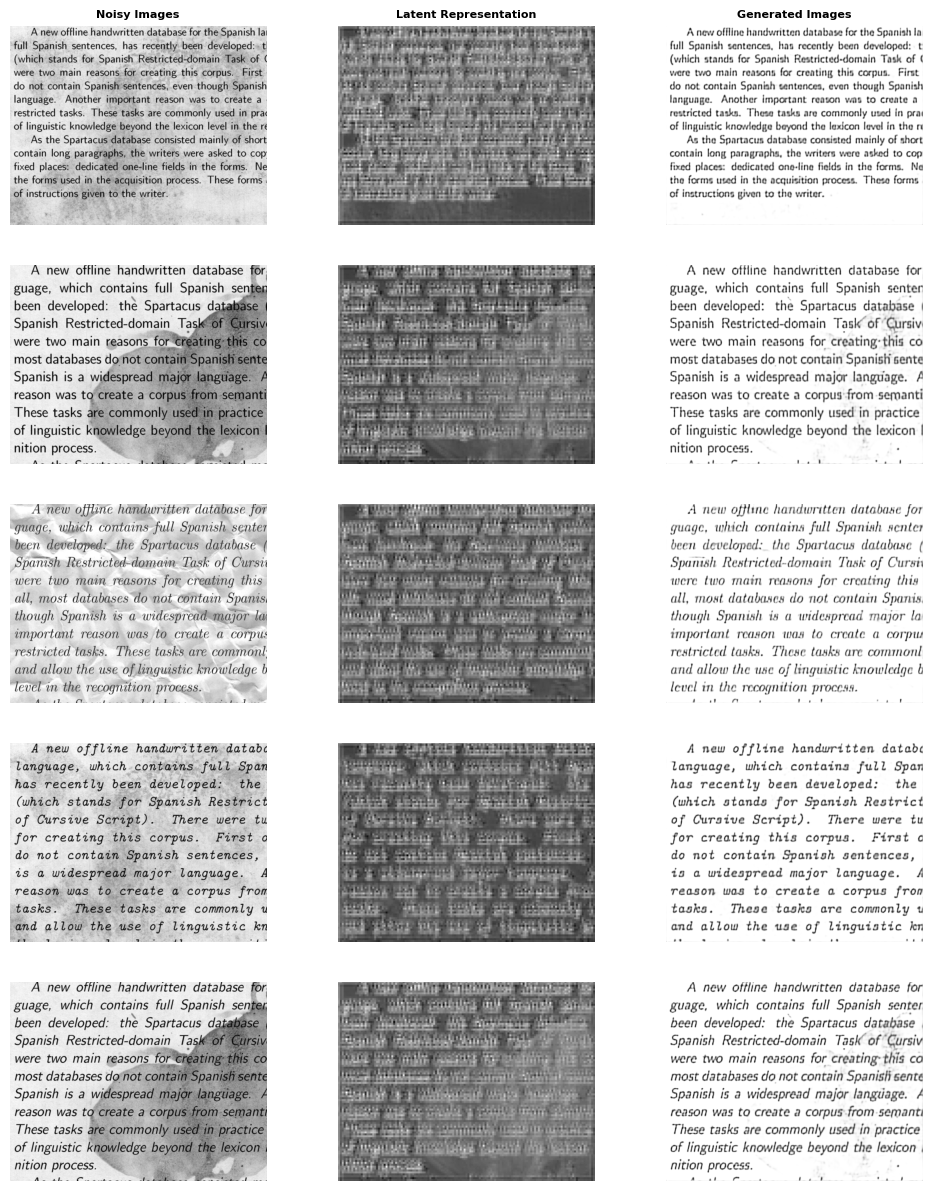

In [81]:
show_images(images_noisy, latent_rep, gen_images, num_examples=5)